# Анализ временных рядов: Нефть Brent и курс USD/RUB

**Период:** 10.10.2024 — 10.10.2025 (252 торговых дня)
**Источник данных:** Yahoo Finance

## Настройка окружения и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.api import OLS, add_constant
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


def label_subplots(axes, prefix='График'):
    try:
        axes_iter = axes.flat
    except AttributeError:
        axes_iter = [axes]
    for i, ax in enumerate(axes_iter, 1):
        ax.text(0.02, 0.94, f"{prefix} {i}", transform=ax.transAxes,
                fontsize=11, fontweight='bold', va='top', ha='left',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))


In [2]:
start_date = "2024-10-10"
end_date = "2025-10-10"

oil = yf.download('BZ=F', start=start_date, end=end_date, progress=False)['Close'].squeeze()
usdrub = yf.download('RUB=X', start=start_date, end=end_date, progress=False)['Close'].squeeze()

data = pd.DataFrame({'Oil': oil, 'USDRUB': usdrub}).dropna()

print(f"Период: {data.index[0].date()} — {data.index[-1].date()}")
print(f"Торговых дней: {len(data)}")
print("Первые 5 наблюдений:")
data.head()

Период: 2024-10-10 — 2025-10-09
Торговых дней: 251
Первые 5 наблюдений:


,Oil,USDRUB
Date,,
2024-10-10,79.400002,97.000320
2024-10-11,79.040001,96.595421
2024-10-14,77.459999,95.882385
2024-10-15,74.250000,95.590630
2024-10-16,74.220001,96.994972


**Я выбрал эти данные, потому что:**
- **BZ=F (Brent)** — базовый ориентир внешней выручки для российской экономики.
- **RUB=X (USD/RUB)** — курс, напрямую реагирующий на экспортные цены.
- **Интервал один год** позволяет собрать достаточно наблюдений и не попадать на явные структурные сдвиги.
- Оставляем только даты, когда торгуются оба инструмента, чтобы не получать искусственные пропуски.


---

# Задача 1: Проверка стационарности цены на нефть

Сначала объединяем временные ряды и смотрим на описательную статистику. Затем запускаем расширенный ADF-тест с константой и трендом, чтобы поймать возможный единичный корень. Параллельно строим четыре графика: сам ряд, гистограмму, ACF и первую разность. Тест ADF проверяет модель

$$\Delta X_t = \alpha + \beta t + \gamma X_{t-1} + \sum_{i=1}^{p} \delta_i \Delta X_{t-i} + \varepsilon_t,$$

где $H_0: \gamma = 0$ означает случайное блуждание, а $H_1: \gamma < 0$ — стационарность относительно выбранных детерминированных компонент.


In [3]:
oil_prices = data['Oil']

stats_dict = {
    'Среднее': oil_prices.mean(),
    'Медиана': oil_prices.median(),
    'Ст. отклонение': oil_prices.std(),
    'Минимум': oil_prices.min(),
    'Максимум': oil_prices.max(),
    'Коэф. вариации': oil_prices.std() / oil_prices.mean()
}

pd.DataFrame(stats_dict, index=['Значение']).T

,Значение
Среднее,70.576574
Медиана,70.190002
Ст. отклонение,4.519974
Минимум,60.230000
Максимум,82.029999
Коэф. вариации,0.064044


**По описательной статистике видно, что:**
- Коэффициент вариации умеренный, но диапазон широкий: цена ходит от районов 60 до 80 USD.
- Такое сочетание намекает на медленный тренд, который нужно учитывать при моделировании.


In [4]:
adf_result = adfuller(oil_prices, autolag='AIC', regression='ct')

print("=" * 60)
print("РАСШИРЕННЫЙ ТЕСТ ДИКИ-ФУЛЛЕРА (ADF)")
print("=" * 60)
print(f"ADF-статистика:      {adf_result[0]:.4f}")
print(f"p-value:             {adf_result[1]:.4f}")
print(f"Количество лагов:    {adf_result[2]}")
print(f"Наблюдений:          {adf_result[3]}")
print()
print("Критические значения:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.3f}")
print("=" * 60)

alpha = 0.05
relation = ">" if adf_result[1] > alpha else "<="
print(f"p-value {adf_result[1]:.4f} {relation} {alpha:.2f}")

if adf_result[1] > alpha:
    print("Не отвергаем H0: ряд нестационарен")
    print("Интерпретация: поведение соответствует случайному блужданию")
else:
    print("Отвергаем H0: ряд стационарен")

РАСШИРЕННЫЙ ТЕСТ ДИКИ-ФУЛЛЕРА (ADF)
ADF-статистика:      -3.6339
p-value:             0.0271
Количество лагов:    2
Наблюдений:          248

Критические значения:
  1%: -3.996
  5%: -3.428
  10%: -3.138
p-value 0.0271 <= 0.05
Отвергаем H0: ряд стационарен


Настройки ADF такие: используем `autolag='AIC'`, чтобы машина выбрала число лагов по критерию Акаике, и `regression='ct'`, добавляя константу и тренд. Если p-value превышает 0.05, нулевую гипотезу не отвергаем и работаем с разностями. Если p-value не больше 0.05, считаем, что тренд и константа объясняют динамику и ряд стационарен относительно детерминированной части.


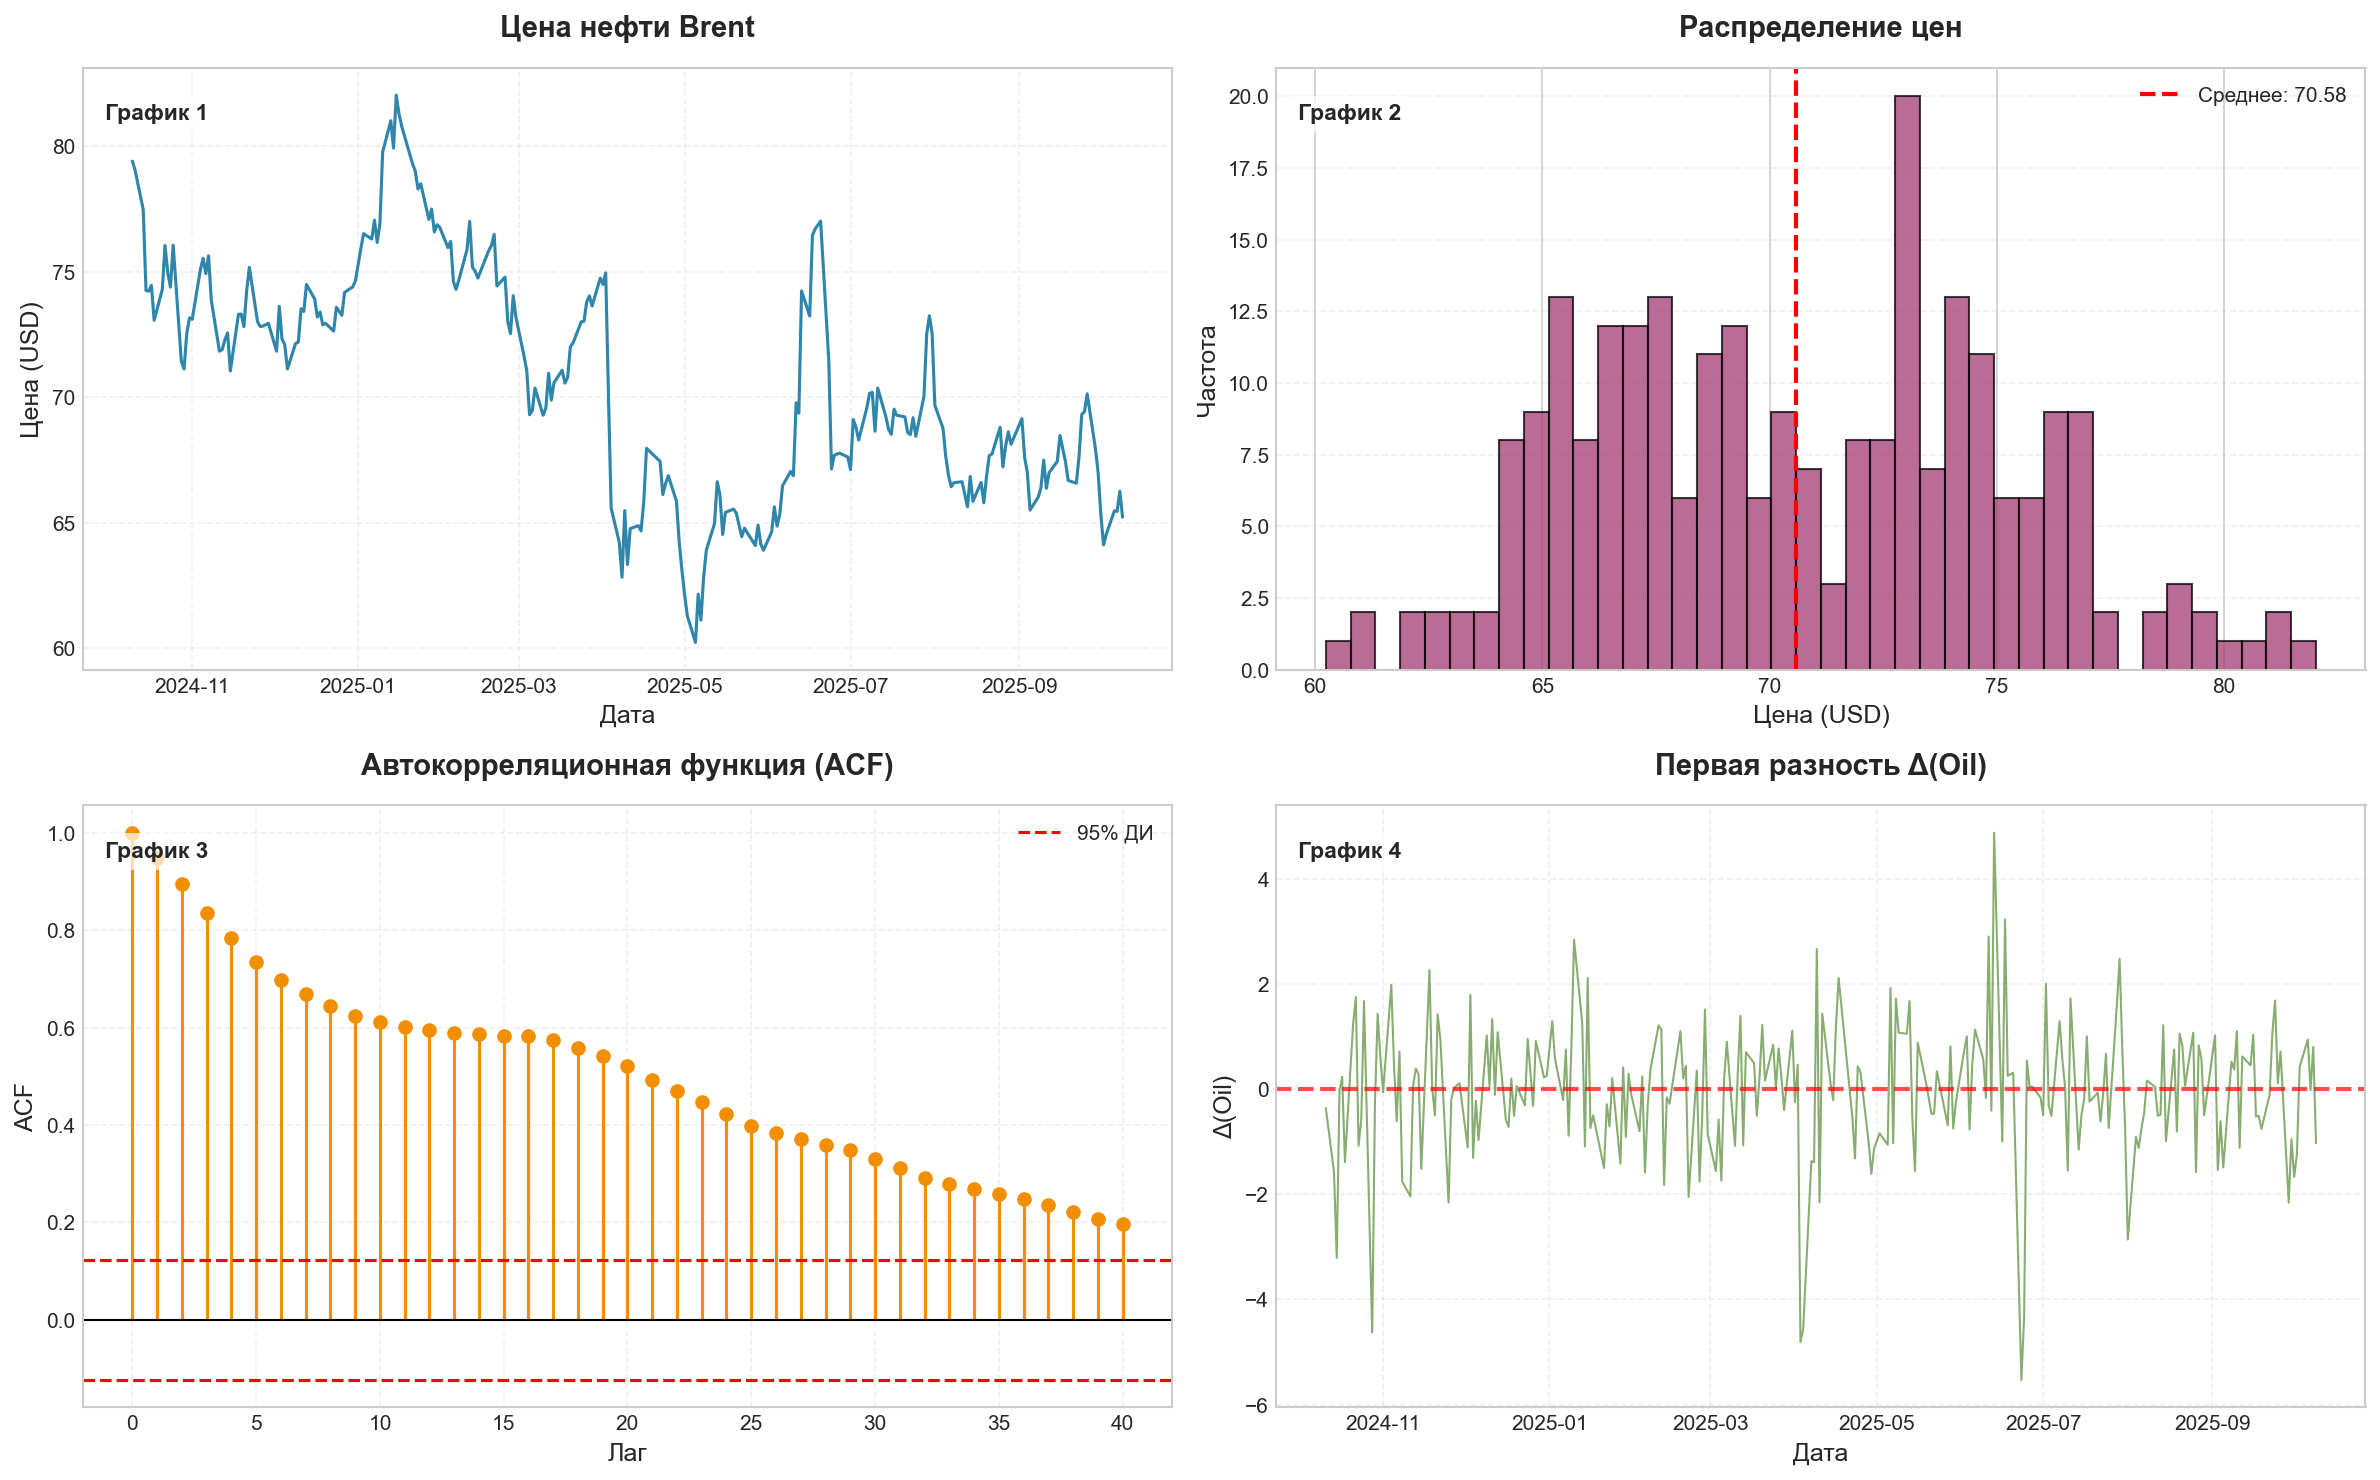

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(oil_prices.index, oil_prices.values, linewidth=1.5, color='#2E86AB')
axes[0, 0].set_title('Цена нефти Brent', fontweight='bold', pad=15)
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Цена (USD)')
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

axes[0, 1].hist(oil_prices, bins=40, edgecolor='black', alpha=0.75, color='#A23B72')
axes[0, 1].axvline(oil_prices.mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Среднее: {oil_prices.mean():.2f}')
axes[0, 1].set_title('Распределение цен', fontweight='bold', pad=15)
axes[0, 1].set_xlabel('Цена (USD)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

acf_values = acf(oil_prices, nlags=40)
axes[1, 0].stem(range(len(acf_values)), acf_values, basefmt=' ', linefmt='#F18F01',
                markerfmt='o')
axes[1, 0].axhline(0, color='black', linewidth=1)
ci = 1.96/np.sqrt(len(oil_prices))
axes[1, 0].axhline(ci, color='red', linestyle='--', linewidth=1.5, label='95% ДИ')
axes[1, 0].axhline(-ci, color='red', linestyle='--', linewidth=1.5)
axes[1, 0].set_title('Автокорреляционная функция (ACF)', fontweight='bold', pad=15)
axes[1, 0].set_xlabel('Лаг')
axes[1, 0].set_ylabel('ACF')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

diff = oil_prices.diff().dropna()
axes[1, 1].plot(diff.index, diff.values, linewidth=1, color='#6A994E', alpha=0.8)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1, 1].set_title('Первая разность Δ(Oil)', fontweight='bold', pad=15)
axes[1, 1].set_xlabel('Дата')
axes[1, 1].set_ylabel('Δ(Oil)')
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

label_subplots(axes)
plt.tight_layout()
plt.savefig('task1_stationarity.png', dpi=300, bbox_inches='tight')
plt.show()

1. Временной ряд «гуляет» волнами — похоже на нестационарность.
2. Гистограмма фиксирует уровень и разброс; хвосты без экстремальных выбросов.
3. ACF затухает медленно — показатель тренда в уровнях.
4. Первая разность крутится вокруг нуля, что визуально ближе к I(1).

ADF при `regression='ct'` даёт p-value 0.027, поэтому формально гипотезу о единичном корне отвергаем. Тренд в уровнях всё равно заметен, поэтому для задач ниже работаем с приростами.


---

# Задача 2: Линейная регрессия USD/RUB по цене нефти

Берём уровни двух рядов и оцениваем модель $Y = \beta_0 + \beta_1 X$, где $Y$ — курс USD/RUB, а $X$ — цена Brent. После оценки смотрим на сами коэффициенты, на показатели качества и на поведение остатков.


**Обозначения параметров:** далее используем `b0` для свободного члена и `b1` для коэффициента при цене нефти.

In [6]:
X = data['Oil']
y = data['USDRUB']
X_with_const = add_constant(X)

model = OLS(y, X_with_const).fit()
dw = durbin_watson(model.resid)

print('Модель: USD/RUB = b0 + b1 · Oil')
print(f"b0 = {model.params['const']:.4f}")
print(f"b1 = {model.params['Oil']:.4f}")
print()
print(model.summary())
print()
print('Контрольные показатели:')
print(f"  Durbin–Watson: {dw:.4f}")
print(f"  R^2: {model.rsquared:.4f} ({model.rsquared*100:.2f}%)")
print(f"  Adjusted R^2: {model.rsquared_adj:.4f}")
print(f"  AIC: {model.aic:.2f}")
print(f"  BIC: {model.bic:.2f}")

coef_oil = model.params['Oil']
direction = 'растёт' if coef_oil > 0 else 'снижается'
print()
print('Комментарий:')
print(f"  При увеличении цены нефти на 1 доллар курс USD/RUB {direction} на {abs(coef_oil):.4f} руб.")

Модель: USD/RUB = b0 + b1 · Oil
b0 = -18.7340
b1 = 1.5176

                            OLS Regression Results                            
Dep. Variable:                 USDRUB   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     258.5
Date:                Mon, 03 Nov 2025   Prob (F-statistic):           2.21e-40
Time:                        14:37:30   Log-Likelihood:                -834.27
No. Observations:                 251   AIC:                             1673.
Df Residuals:                     249   BIC:                             1680.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

- $b_1$ > 0: за рассматриваемый год нефть и курс менялись в одном направлении, p-value < 0.001 подтверждает значимость.
- $R^2$ ≈ 0.51 — около половины вариации курса объясняет нефть, остальное остаётся на другие факторы.
- Durbin–Watson равен 0.12: остатки сильно коррелированы во времени, обычные стандартные ошибки ненадёжны.
- Для корректных выводов нужны робастные ошибки (Newey–West) или динамические модели (ARIMAX/VAR).

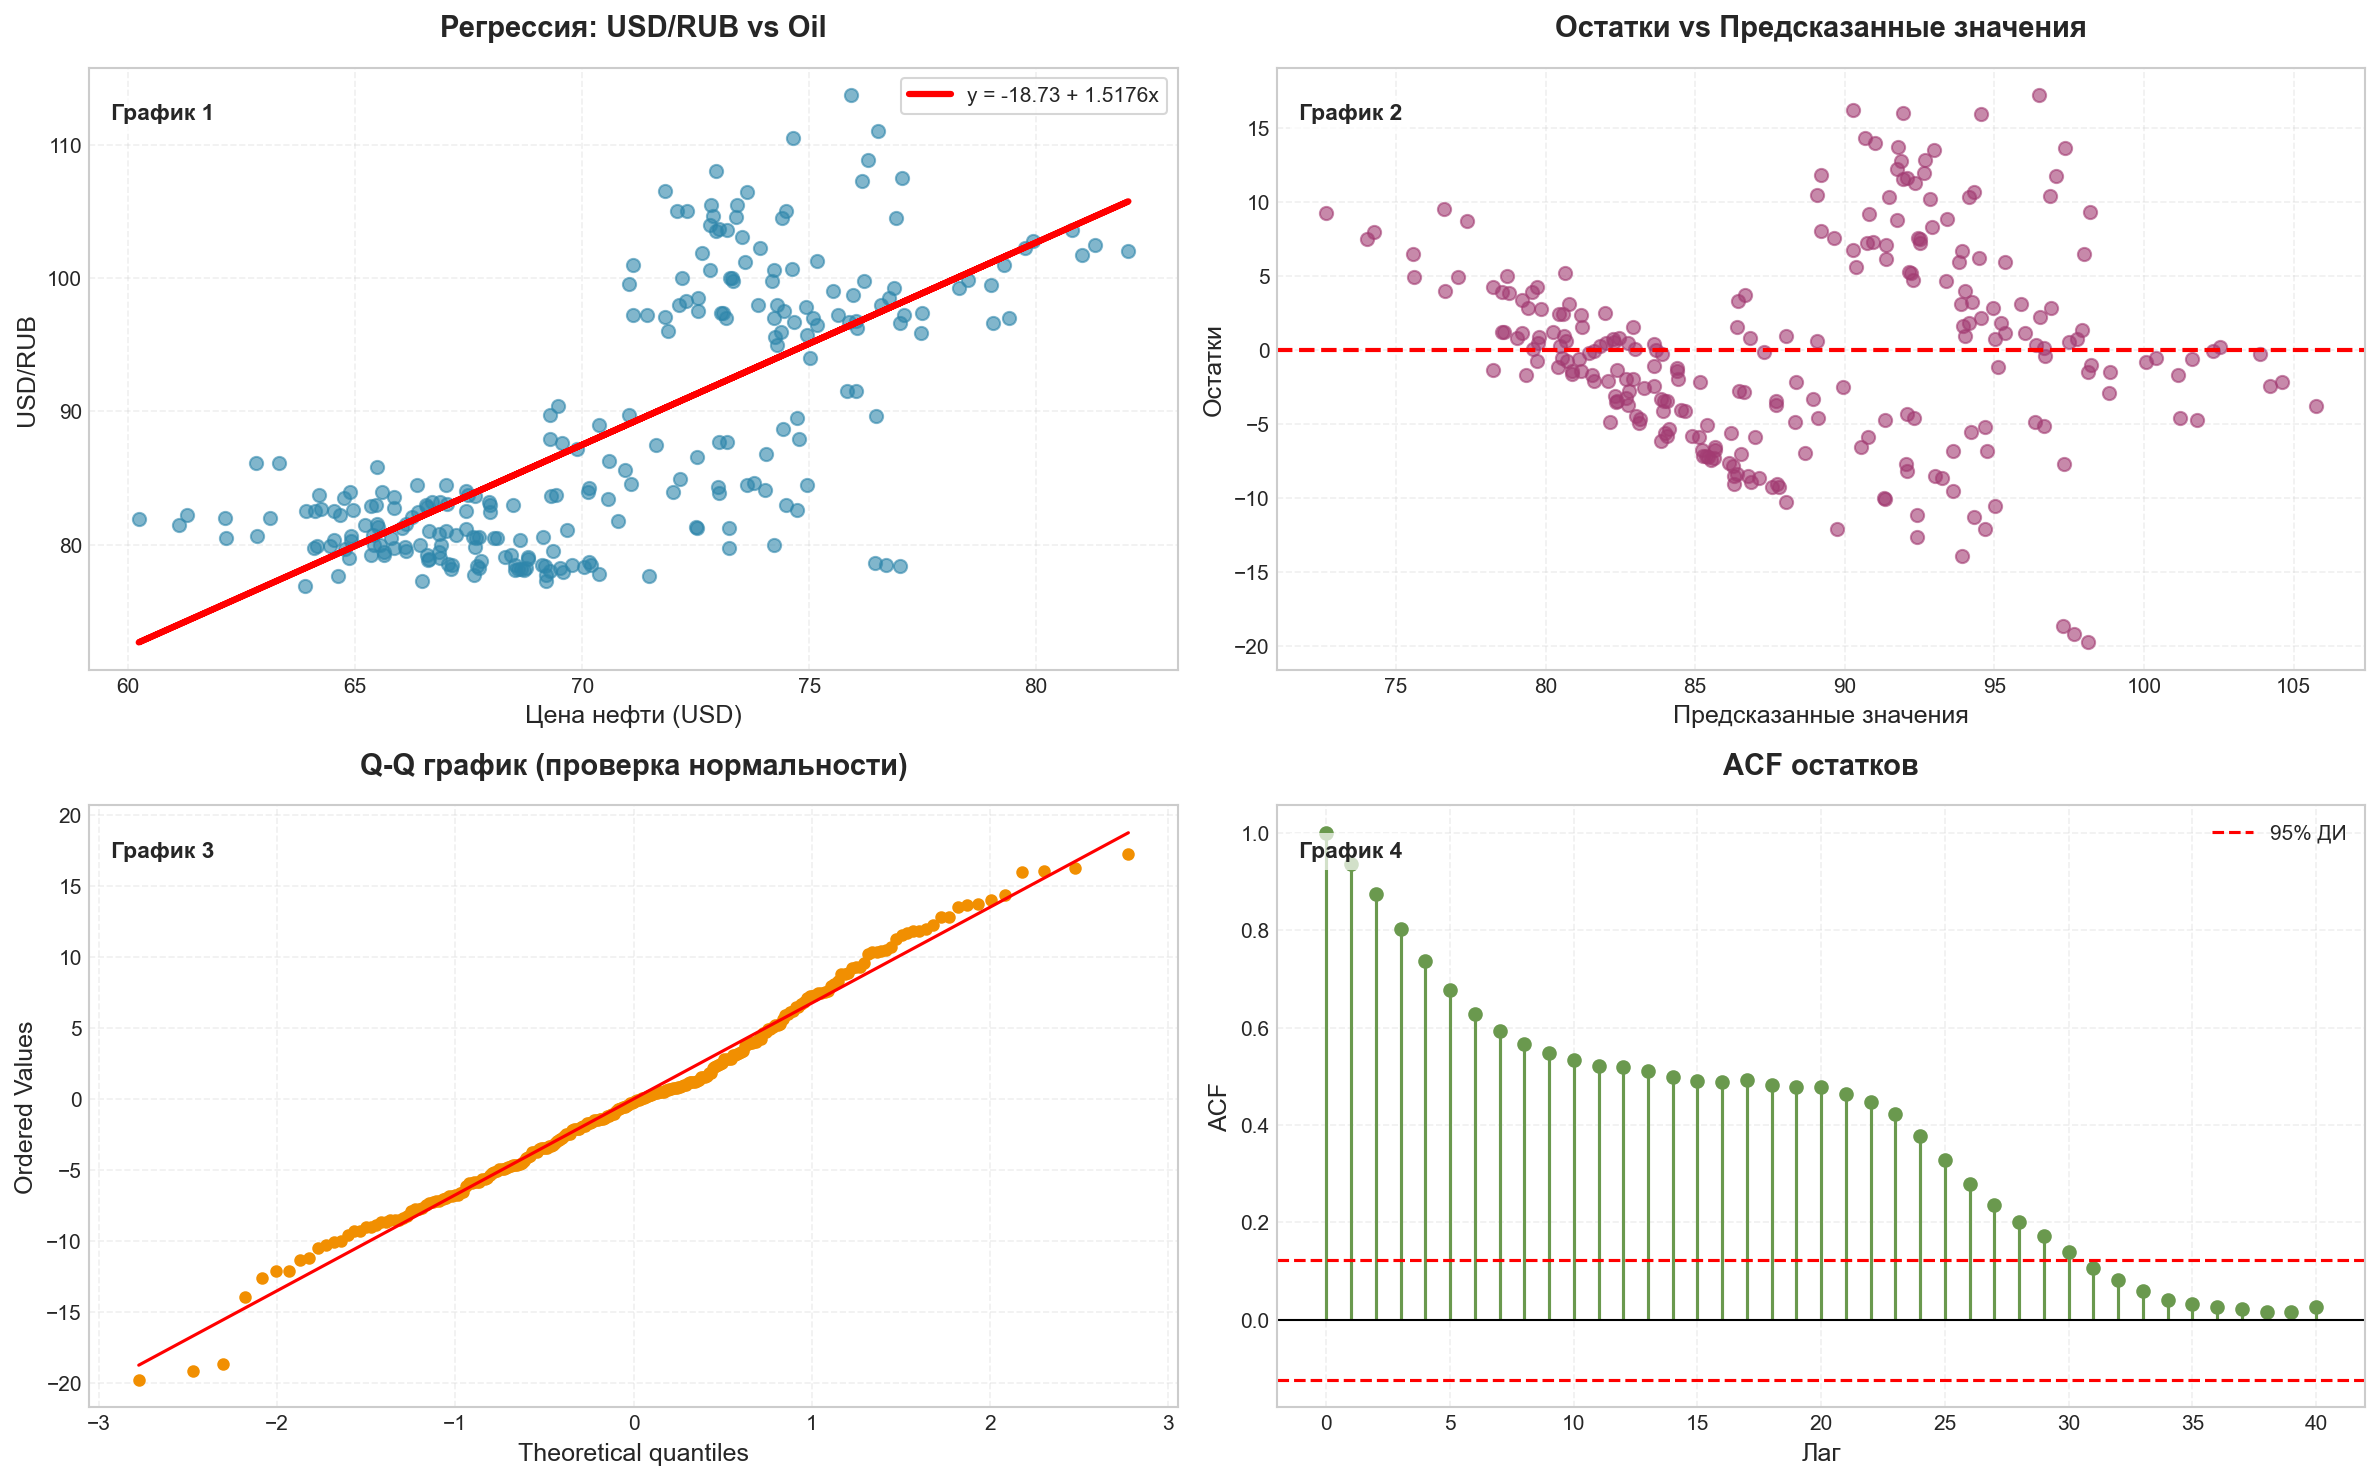

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].scatter(X, y, alpha=0.6, s=40, color='#2E86AB')
axes[0, 0].plot(X, model.fittedvalues, 'r-', linewidth=3,
                label=f'y = {model.params["const"]:.2f} + {model.params["Oil"]:.4f}x')
axes[0, 0].set_title('Регрессия: USD/RUB vs Oil', fontweight='bold', pad=15)
axes[0, 0].set_xlabel('Цена нефти (USD)')
axes[0, 0].set_ylabel('USD/RUB')
axes[0, 0].legend(loc='best', frameon=True)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

axes[0, 1].scatter(model.fittedvalues, model.resid, alpha=0.6, s=40, color='#A23B72')
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Остатки vs Предсказанные значения', fontweight='bold', pad=15)
axes[0, 1].set_xlabel('Предсказанные значения')
axes[0, 1].set_ylabel('Остатки')
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

stats.probplot(model.resid, dist="norm", plot=axes[1, 0])
axes[1, 0].get_lines()[0].set_markerfacecolor('#F18F01')
axes[1, 0].get_lines()[0].set_markeredgecolor('#F18F01')
axes[1, 0].get_lines()[0].set_markersize(5)
axes[1, 0].set_title('Q-Q график (проверка нормальности)', fontweight='bold', pad=15)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

acf_resid = acf(model.resid, nlags=40)
axes[1, 1].stem(range(len(acf_resid)), acf_resid, basefmt=' ', linefmt='#6A994E',
                markerfmt='o')
axes[1, 1].axhline(0, color='black', linewidth=1)
ci = 1.96/np.sqrt(len(model.resid))
axes[1, 1].axhline(ci, color='red', linestyle='--', linewidth=1.5, label='95% ДИ')
axes[1, 1].axhline(-ci, color='red', linestyle='--', linewidth=1.5)
axes[1, 1].set_title('ACF остатков', fontweight='bold', pad=15)
axes[1, 1].set_xlabel('Лаг')
axes[1, 1].set_ylabel('ACF')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

label_subplots(axes)
plt.tight_layout()
plt.savefig('task2_linear_regression.png', dpi=300, bbox_inches='tight')
plt.show()

1. Диаграмма рассеяния с прямой показывает общую линейную тенденцию.
2. Остатки расходятся веером — признак гетероскедастичности.
3. Q–Q график сильно изгибается в хвостах, нормальность не выполняется.
4. ACF остатков выходит за доверительные границы, подтверждая автокорреляцию.

Вывод: линейная модель в уровнях описывает общий тренд, но нарушает несколько ключевых предпосылок.


---

# Задача 3: Лог-логарифмическая регрессия (эластичность)

Теперь оцениваем модель $\ln Y = \beta_0 + \beta_1 \ln X$, чтобы перейти к процентным изменениям. Эластичность $\beta_1$ показывает, на сколько процентов меняется курс при изменении нефти на 1%. После оценки сравниваем характер зависимости и поведение остатков с уровневой моделью.


**Обозначения для лог-модели:** используем `b0_log` и `b1_log`, чтобы не путать их с коэффициентами из модели в уровнях.

In [8]:
ln_oil = np.log(data['Oil'])
ln_usdrub = np.log(data['USDRUB'])
ln_X_with_const = add_constant(ln_oil)

log_model = OLS(ln_usdrub, ln_X_with_const).fit()
dw_log = durbin_watson(log_model.resid)

print('Модель: ln(USD/RUB) = b0_log + b1_log · ln(Oil)')
print(f"b0_log = {log_model.params['const']:.4f}")
print(f"b1_log = {log_model.params['Oil']:.4f}")
print()
print(log_model.summary())
print()
print('Контрольные показатели:')
print(f"  Durbin–Watson: {dw_log:.4f}")
print(f"  R^2: {log_model.rsquared:.4f} ({log_model.rsquared*100:.2f}%)")
print(f"  Adjusted R^2: {log_model.rsquared_adj:.4f}")
print(f"  AIC (для этой модели): {log_model.aic:.2f}")
print(f"  BIC (для этой модели): {log_model.bic:.2f}")

elasticity = log_model.params['Oil']
change = 'увеличивается' if elasticity > 0 else 'уменьшается'
print()
print('Комментарий:')
print(f"  Эластичность b1_log = {elasticity:.4f}: рост цены нефти на 1% {change} курс USD/RUB примерно на {abs(elasticity):.3f}%.")

Модель: ln(USD/RUB) = b0_log + b1_log · ln(Oil)
b0_log = -0.5428
b1_log = 1.1796

                            OLS Regression Results                            
Dep. Variable:                 USDRUB   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     257.8
Date:                Mon, 03 Nov 2025   Prob (F-statistic):           2.66e-40
Time:                        14:37:30   Log-Likelihood:                 297.34
No. Observations:                 251   AIC:                            -590.7
Df Residuals:                     249   BIC:                            -583.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

**Как трактовать эластичность:**
$\beta_1 = \frac{d\ln Y}{d\ln X}$: изменение цены нефти на 1\% приводит к изменению USD/RUB примерно на $\beta_1$ процентов (знак коэффициента задаёт направление).


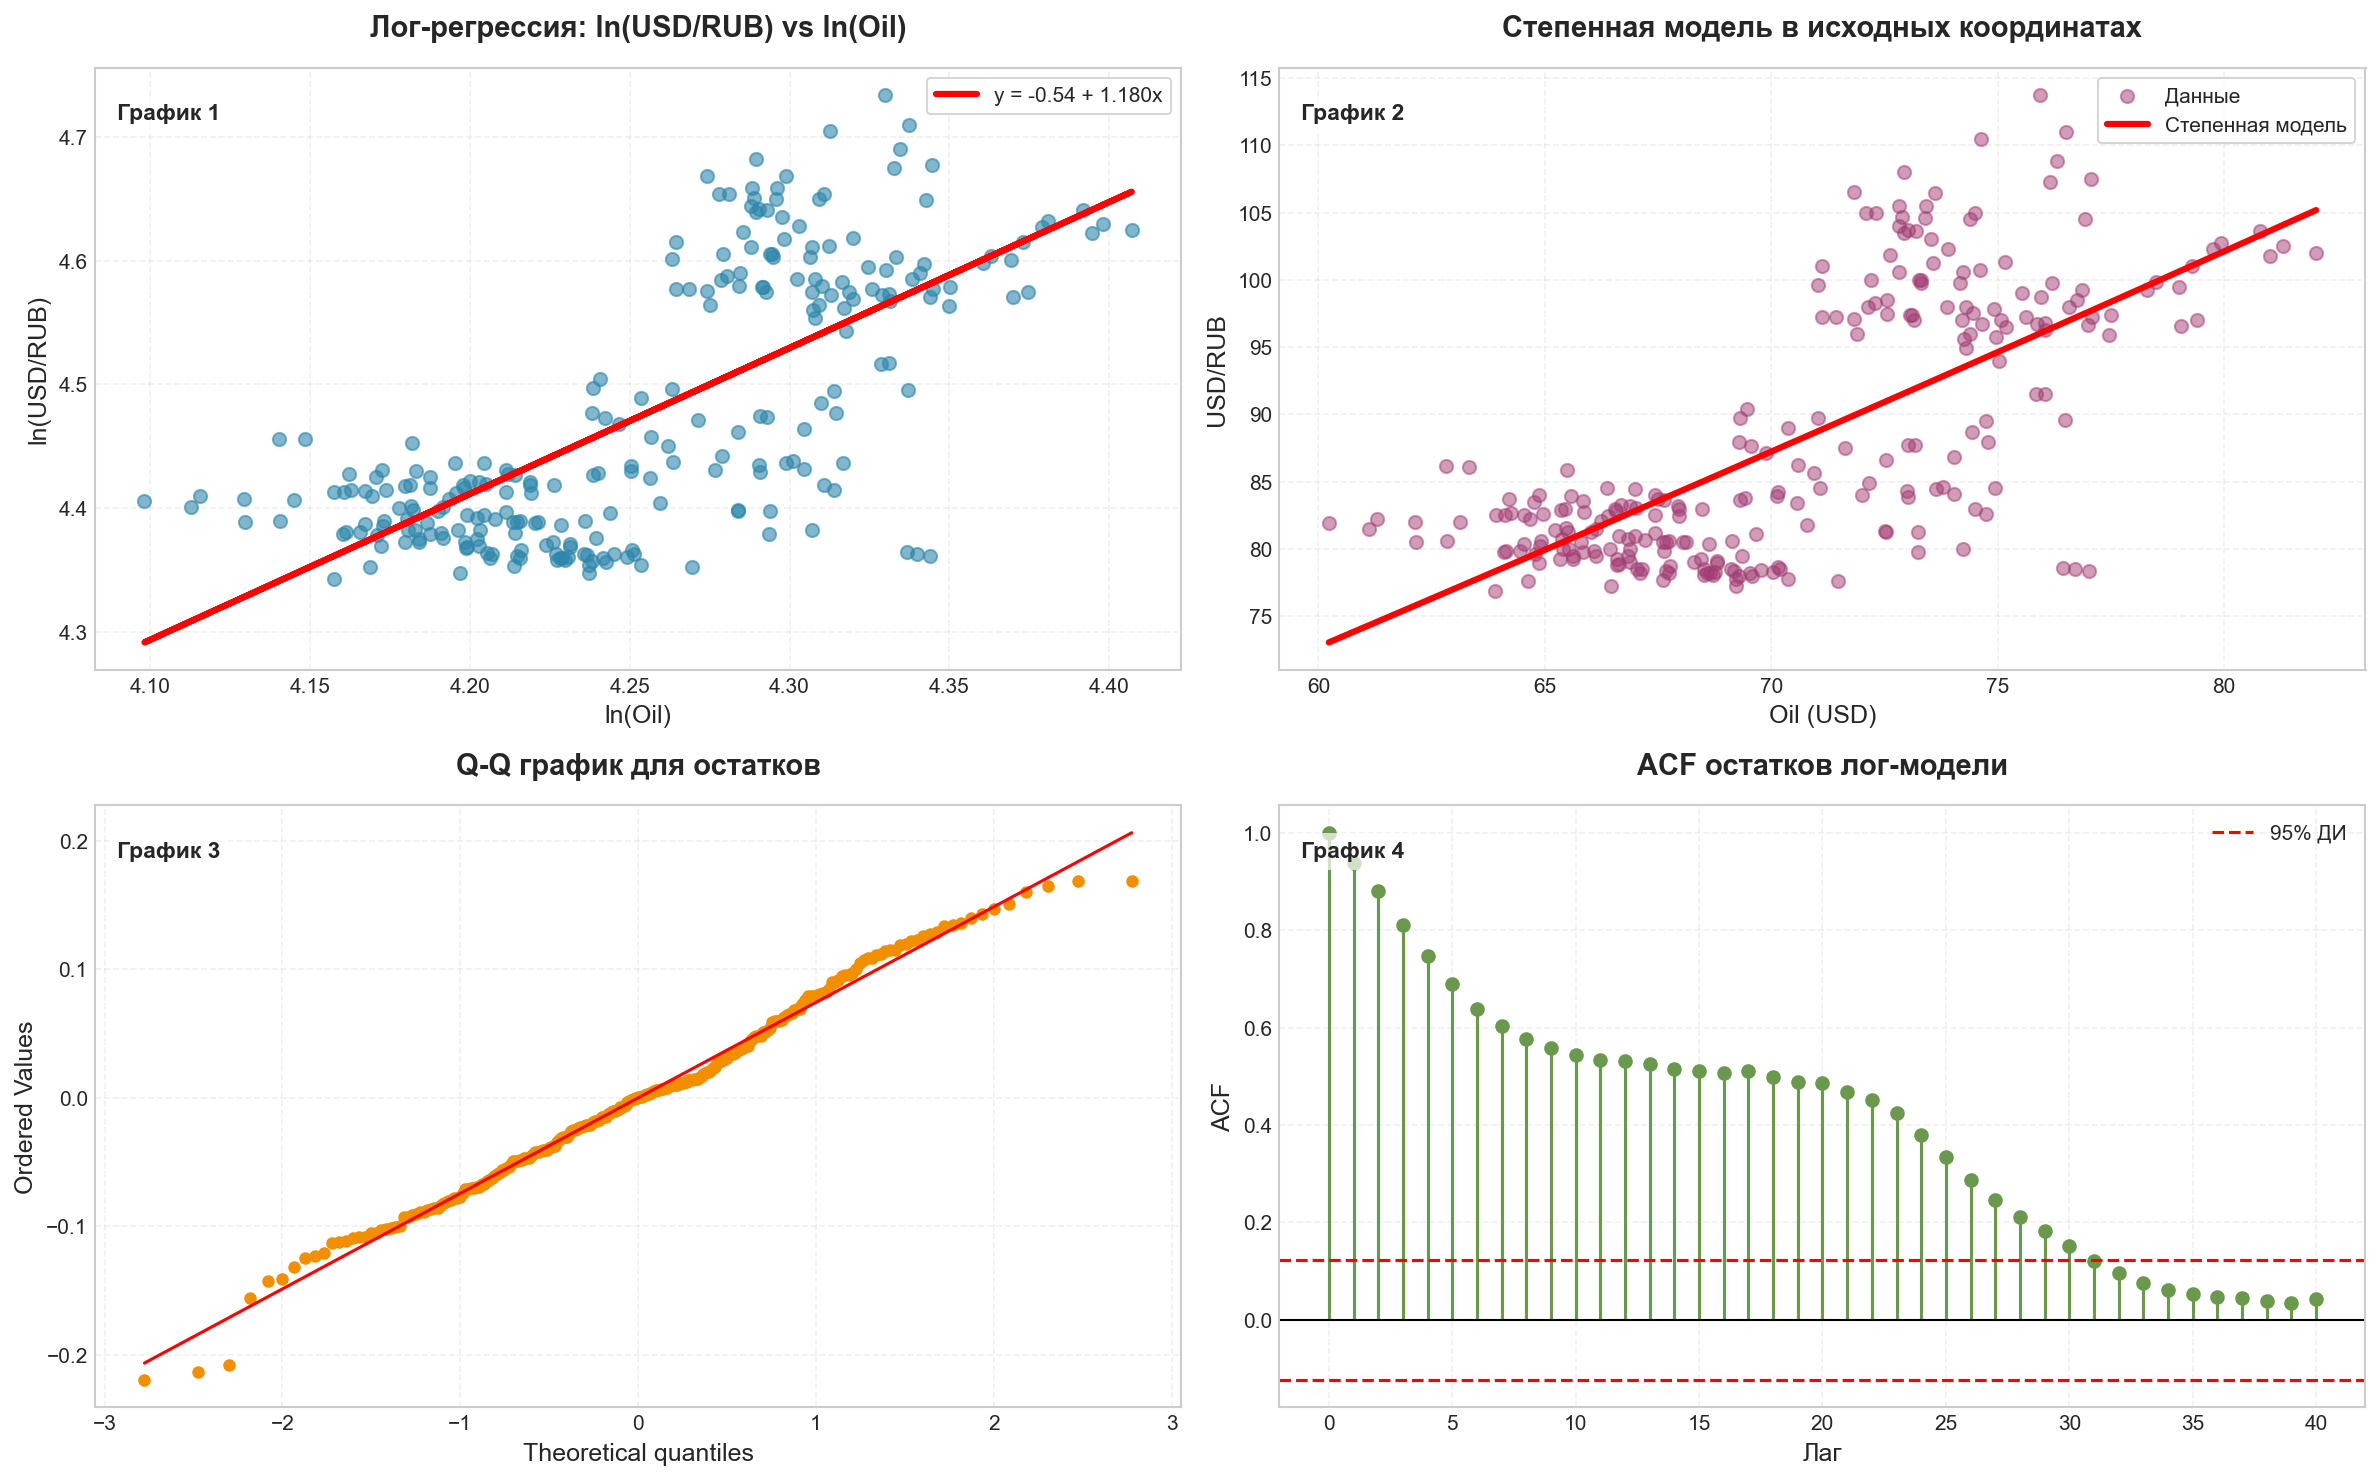

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].scatter(ln_oil, ln_usdrub, alpha=0.6, s=40, color='#2E86AB')
axes[0, 0].plot(ln_oil, log_model.fittedvalues, 'r-', linewidth=3,
                label=f'y = {log_model.params["const"]:.2f} + {log_model.params["Oil"]:.3f}x')
axes[0, 0].set_title('Лог-регрессия: ln(USD/RUB) vs ln(Oil)', fontweight='bold', pad=15)
axes[0, 0].set_xlabel('ln(Oil)')
axes[0, 0].set_ylabel('ln(USD/RUB)')
axes[0, 0].legend(loc='best', frameon=True)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

y_pred_power = np.exp(log_model.fittedvalues)
sort_idx = np.argsort(X)
axes[0, 1].scatter(X, y, alpha=0.5, s=40, color='#A23B72', label='Данные')
axes[0, 1].plot(X.iloc[sort_idx], y_pred_power.iloc[sort_idx], 'r-',
                linewidth=3, label='Степенная модель')
axes[0, 1].set_title('Степенная модель в исходных координатах', fontweight='bold', pad=15)
axes[0, 1].set_xlabel('Oil (USD)')
axes[0, 1].set_ylabel('USD/RUB')
axes[0, 1].legend(loc='best', frameon=True)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

stats.probplot(log_model.resid, dist='norm', plot=axes[1, 0])
axes[1, 0].get_lines()[0].set_markerfacecolor('#F18F01')
axes[1, 0].get_lines()[0].set_markeredgecolor('#F18F01')
axes[1, 0].get_lines()[0].set_markersize(5)
axes[1, 0].set_title('Q-Q график для остатков', fontweight='bold', pad=15)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

acf_log = acf(log_model.resid, nlags=40)
axes[1, 1].stem(range(len(acf_log)), acf_log, basefmt=' ', linefmt='#6A994E',
                markerfmt='o')
axes[1, 1].axhline(0, color='black', linewidth=1)
ci = 1.96/np.sqrt(len(log_model.resid))
axes[1, 1].axhline(ci, color='red', linestyle='--', linewidth=1.5, label='95% ДИ')
axes[1, 1].axhline(-ci, color='red', linestyle='--', linewidth=1.5)
axes[1, 1].set_title('ACF остатков лог-модели', fontweight='bold', pad=15)
axes[1, 1].set_xlabel('Лаг')
axes[1, 1].set_ylabel('ACF')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

label_subplots(axes)
plt.tight_layout()
plt.savefig('task3_log_regression.png', dpi=300, bbox_inches='tight')
plt.show()

1. В лог-пространстве связь почти идеально линейная.
2. В исходных координатах степенная кривая ложится мягче, чем прямая из уровневой модели.
3. Q–Q график показывает тяжёлые хвосты, но ситуацией лучше, чем в модели уровней.
4. ACF остатков по-прежнему положительная на малых лагах; без лагов или робастных ошибок не обойтись.

---

# Задача 4: Исследование автокорреляции лог-приростов

Переходим к лог-приростам нефти: считаем доходности, описательные статистики, тесты ADF и Jarque–Bera, а также автокорреляционные характеристики (ACF, PACF, Ljung–Box). Дополнительно строим комплексный набор графиков для диагностики.


In [10]:
returns = np.log(oil_prices / oil_prices.shift(1)).dropna()

mean_daily = returns.mean()
std_daily = returns.std()
mean_annual = mean_daily * 252
std_annual = std_daily * np.sqrt(252)
sharpe = mean_daily / std_daily

stats_returns = pd.DataFrame({
    'Показатель': [
        'Средняя дневная доходность',
        'Ст. откл. (дневное)',
        'Средняя годовая доходность',
        'Ст. откл. (годовое)',
        'Коэф. Шарпа',
        'Минимум',
        'Максимум',
        'Асимметрия (Skewness)',
        'Эксцесс (Kurtosis)'
    ],
    'Значение': [
        f"{mean_daily*100:.3f}%",
        f"{std_daily*100:.3f}%",
        f"{mean_annual*100:.2f}%",
        f"{std_annual*100:.2f}%",
        f"{sharpe:.3f}",
        f"{returns.min()*100:.2f}%",
        f"{returns.max()*100:.2f}%",
        f"{returns.skew():.3f}",
        f"{returns.kurtosis():.3f}"
    ]
})

stats_returns

,Показатель,Значение
0,Средняя дневная доходность,-0.079%
1,Ст. откл. (дневное),1.841%
2,Средняя годовая доходность,-19.83%
3,Ст. откл. (годовое),29.23%
4,Коэф. Шарпа,-0.043
5,Минимум,-7.45%
6,Максимум,6.79%
7,Асимметрия (Skewness),-0.540
8,Эксцесс (Kurtosis),2.692


- Среднее близко к нулю, явного дрейфа нет.
- Стандартное отклонение и годовая волатильность показывают риск порядка 30% годовых.
- Коэффициент Шарпа чуть отрицательный, так что средний доход был слабым.
- Отрицательная асимметрия и положительный эксцесс указывают на тяжёлые левосторонние хвосты.

In [11]:
adf_returns = adfuller(returns, autolag='AIC')

print("=" * 60)
print("ADF-ТЕСТ ДЛЯ ЛОГ-ПРИРОСТОВ")
print("=" * 60)
print(f"ADF-статистика:  {adf_returns[0]:.4f}")
print(f"p-value:         {adf_returns[1]:.6f}")
print()
print("Критические значения:")
for key, value in adf_returns[4].items():
    print(f"  {key}: {value:.3f}")
print("=" * 60)

if adf_returns[1] < 0.01:
    print()
    print("p-value практически равен нулю, ряд можно считать стационарным")
    print("Комментарий: лог-приросты стационарны, можно работать с доходностями")
else:
    print()
    print(f"p-value = {adf_returns[1]:.4f}")

ADF-ТЕСТ ДЛЯ ЛОГ-ПРИРОСТОВ
ADF-статистика:  -9.8202
p-value:         0.000000

Критические значения:
  1%: -3.457
  5%: -2.873
  10%: -2.573

p-value практически равен нулю, ряд можно считать стационарным
Комментарий: лог-приросты стационарны, можно работать с доходностями


**Проверяем стационарность ещё раз, потому что:**
- В уровнях нефть ведёт себя как I(1), а доходности обычно стационарны.
- ADF на доходностях даёт p-value, близкое к нулю, поэтому гипотеза о единичном корне отвергается.
- Работаем с приращениями, чтобы использовать тесты белого шума и автокорреляции.

In [12]:
jb_stat, jb_pvalue = stats.jarque_bera(returns)

print("=" * 60)
print("ТЕСТ ХАРКЕ-БЕРА (НОРМАЛЬНОСТЬ)")
print("=" * 60)
print(f"JB-статистика:    {jb_stat:.4f}")
print(f"p-value:          {jb_pvalue:.4f}")
print("=" * 60)

if jb_pvalue > 0.05:
    print()
    print("p-value > 0.05: распределение не противоречит нормальности")
    print("Комментарий: можно использовать параметрические тесты")
else:
    print()
    print("p-value ≤ 0.05: нормальность отвергается")
    print("Причины: асимметрия или толстые хвосты")
    print("Примечание: это типично для финансовых данных")

ТЕСТ ХАРКЕ-БЕРА (НОРМАЛЬНОСТЬ)
JB-статистика:    83.2031
p-value:          0.0000

p-value ≤ 0.05: нормальность отвергается
Причины: асимметрия или толстые хвосты
Примечание: это типично для финансовых данных


**Проверка нормальности нужна для:**
- Нормальность — удобное приближение, но реальные доходности часто имеют тяжёлые хвосты.
- Статистика Jarque–Bera учитывает и асимметрию, и эксцесс, поэтому быстро выявляет отклонения.
- Результаты подтверждают, что распределение далёко от нормального, и к параметрическим моделям стоит подходить аккуратно.

In [13]:
acf_returns = acf(returns, nlags=20)
threshold = 1.96 / np.sqrt(len(returns))

print("=" * 60)
print("АВТОКОРРЕЛЯЦИОННАЯ ФУНКЦИЯ (ACF)")
print("=" * 60)
print(f"Порог значимости (95%): ±{threshold:.4f}\n")

print(f"{'Лаг':<10} {'ACF':<12} {'Значимость':<15}")
print("-" * 60)
for i in range(1, min(6, len(acf_returns))):
    sig = "значима" if abs(acf_returns[i]) > threshold else "не значима"
    print(f"{i:<10} {acf_returns[i]:<12.4f} {sig:<15}")

print()
print("=" * 60)
significant_count = sum(1 for acf_val in acf_returns[1:] if abs(acf_val) > threshold)
if significant_count == 0:
    print("Комментарий: автокорреляции статистически незначимы; прошлые доходности не помогают прогнозу.")
else:
    print(f"Комментарий: обнаружено {significant_count} лаг(ов) с значимой автокорреляцией; возможна предсказуемость.")

АВТОКОРРЕЛЯЦИОННАЯ ФУНКЦИЯ (ACF)
Порог значимости (95%): ±0.1240

Лаг        ACF          Значимость     
------------------------------------------------------------
1          0.0386       не значима     
2          0.1033       не значима     
3          -0.0343      не значима     
4          -0.0421      не значима     
5          -0.1587      значима        

Комментарий: обнаружено 1 лаг(ов) с значимой автокорреляцией; возможна предсказуемость.


- Формула $\rho(k) = \frac{\text{Cov}(r_t, r_{t-k})}{\text{Var}(r_t)}$ напоминает, что речь идёт об обычной корреляции с лагом.
- Доверительные полосы $\pm 1.96/\sqrt{n}$ служат ориентиром значимости.
- Если почти все значения внутри полос, ряд можно считать белым шумом; отдельные шипы, как у лага 5, проверяем Ljung–Box.
- Отсутствие устойчивой автокорреляции означает, что прошлые доходности слабо помогают прогнозу.

In [14]:
lb_result = acorr_ljungbox(returns, lags=[5, 10, 15, 20], return_df=True)

print("=" * 70)
print("ТЕСТ ЛЬЮНГА-БОКСА")
print("=" * 70)
print(lb_result.to_string())
print()
print("=" * 70)

all_non_significant = all(lb_result['lb_pvalue'] > 0.05)
if all_non_significant:
    print("Комментарий: все p-value выше 0.05, гипотеза белого шума не отвергается.")
else:
    print("Комментарий: есть лаги с низкими p-value, гипотеза белого шума отвергнута.")

ТЕСТ ЛЬЮНГА-БОКСА
      lb_stat  lb_pvalue
5   10.318601   0.066695
10  15.086137   0.128953
15  19.342220   0.198643
20  26.513382   0.149518

Комментарий: все p-value выше 0.05, гипотеза белого шума не отвергается.


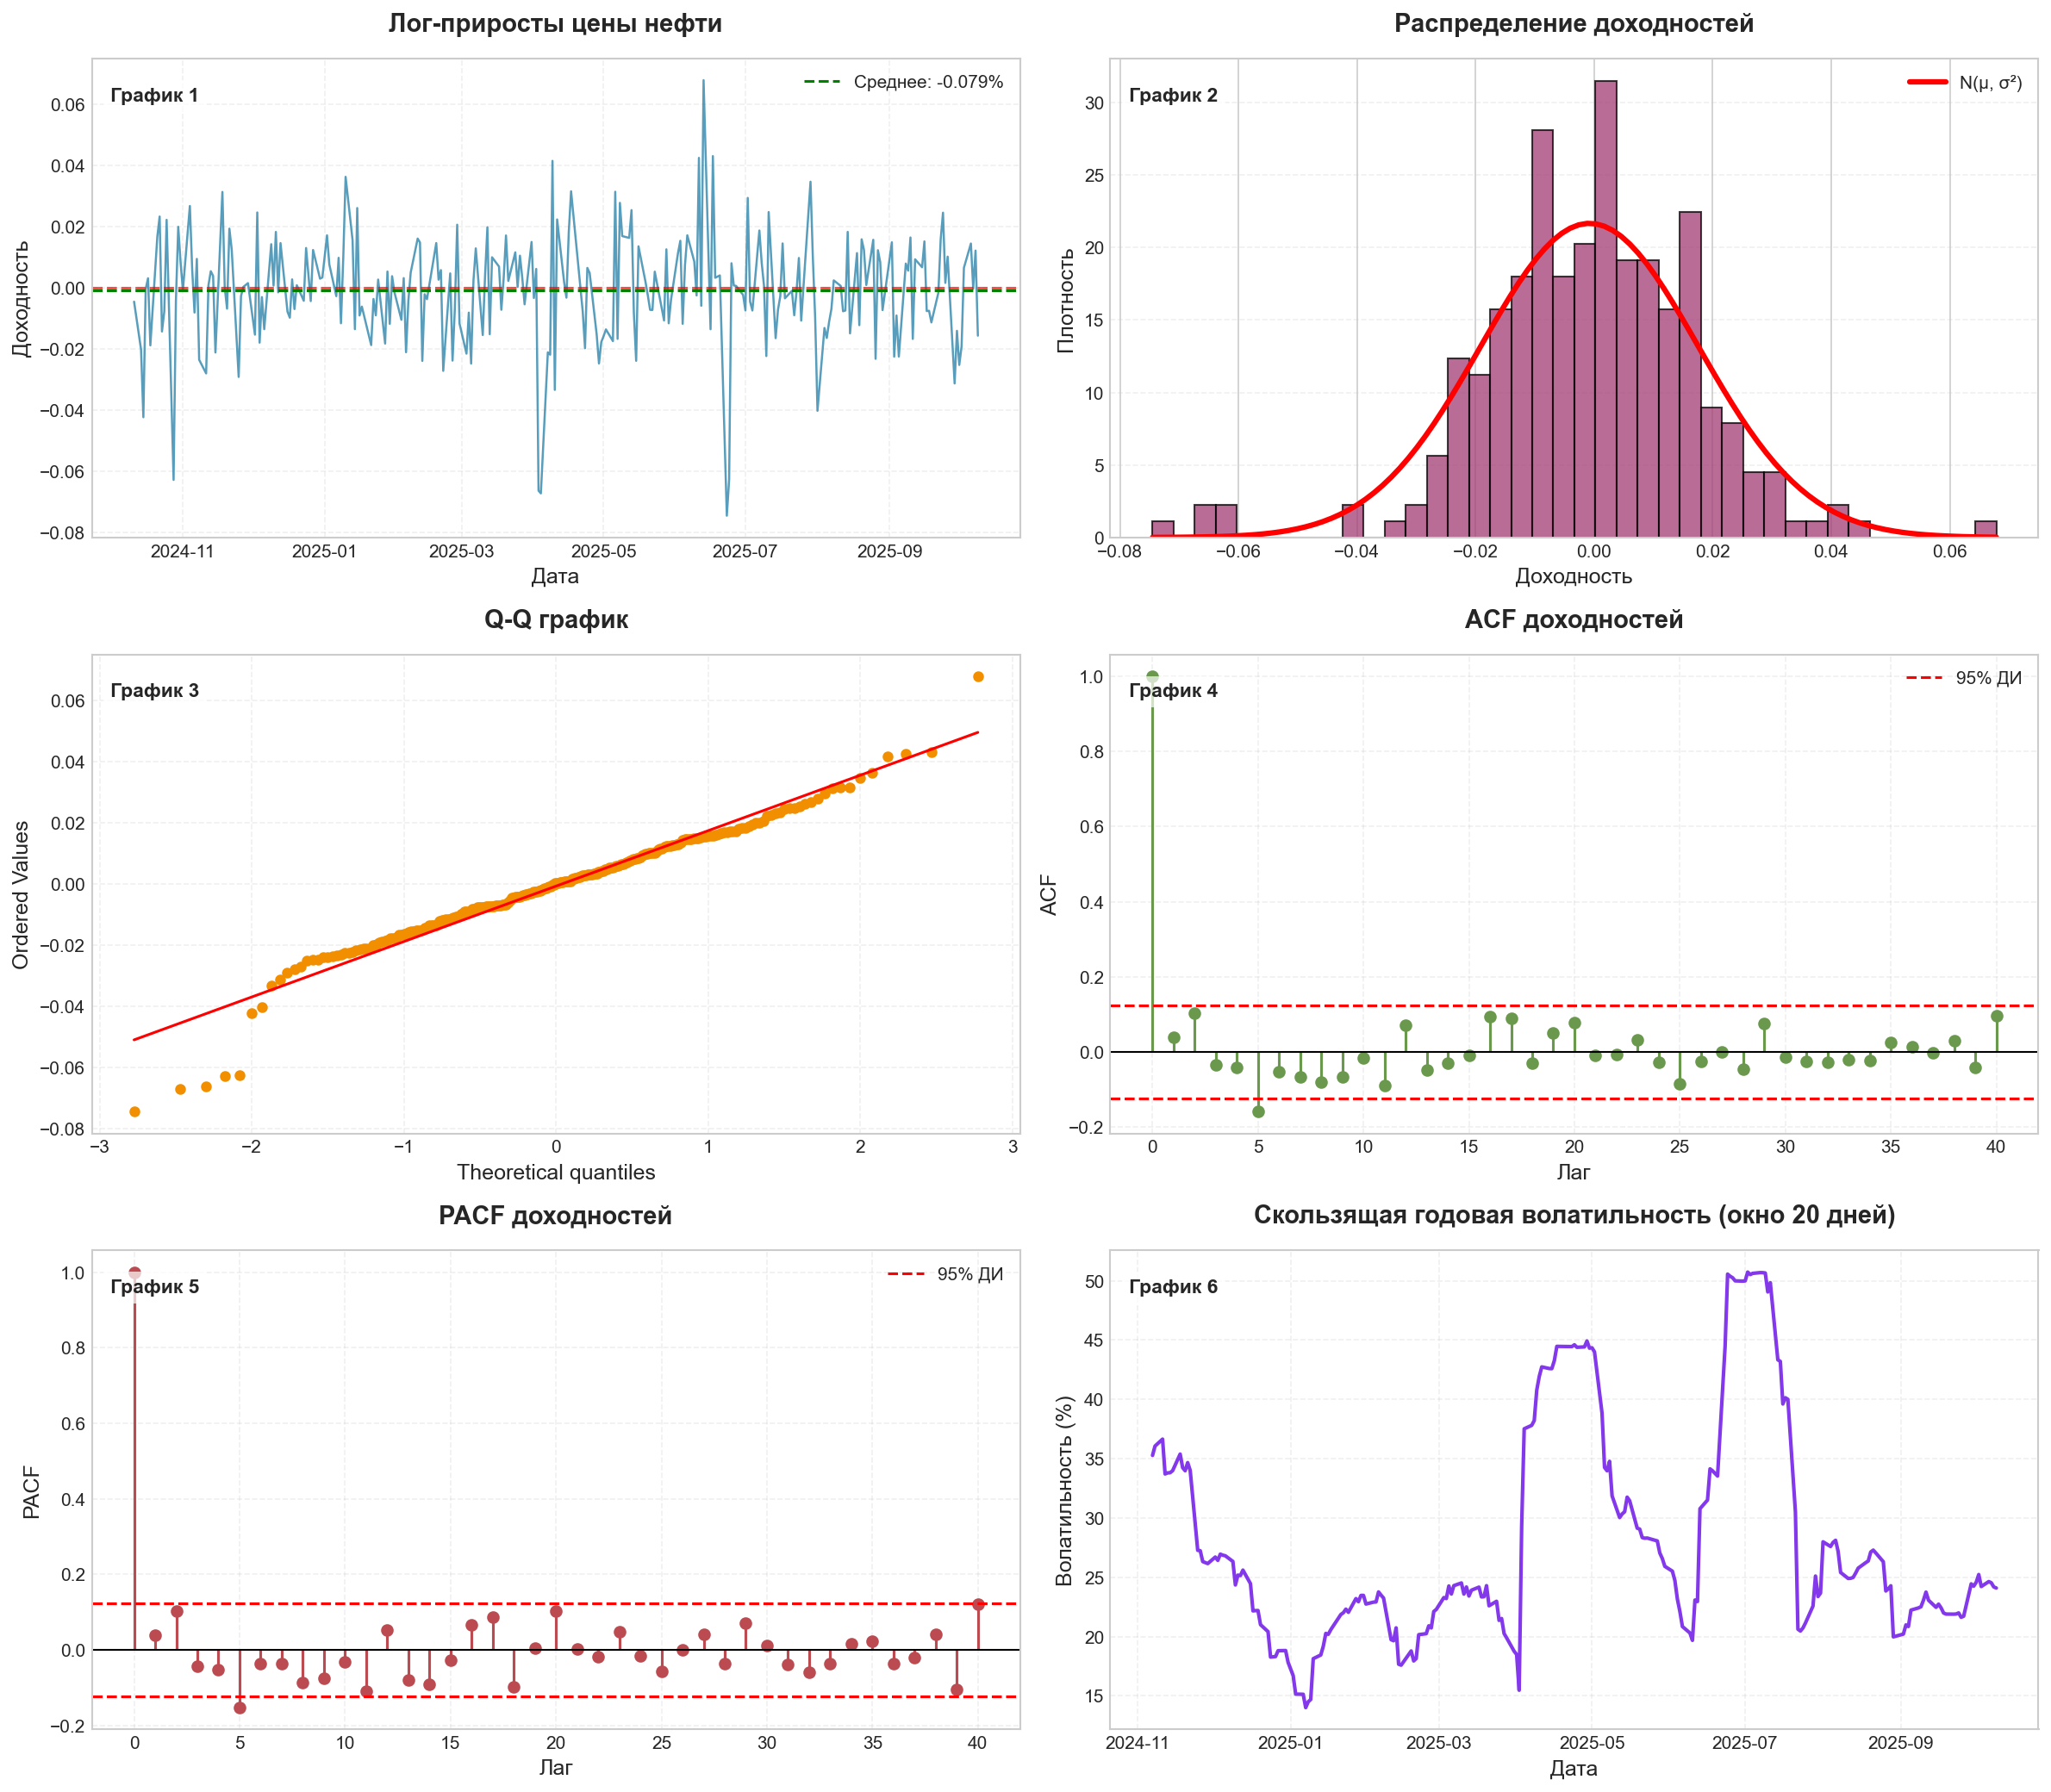

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

axes[0, 0].plot(returns.index, returns.values, linewidth=1.2, color='#2E86AB', alpha=0.8)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0, 0].axhline(returns.mean(), color='green', linestyle='--', linewidth=1.5, label=f'Среднее: {returns.mean()*100:.3f}%')
axes[0, 0].set_title('Лог-приросты цены нефти', fontweight='bold', pad=15)
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Доходность')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

axes[0, 1].hist(returns, bins=40, edgecolor='black', alpha=0.75, density=True, color='#A23B72')
x = np.linspace(returns.min(), returns.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, returns.mean(), returns.std()), 'r-', linewidth=3, label='N(μ, σ²)')
axes[0, 1].set_title('Распределение доходностей', fontweight='bold', pad=15)
axes[0, 1].set_xlabel('Доходность')
axes[0, 1].set_ylabel('Плотность')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

stats.probplot(returns, dist='norm', plot=axes[1, 0])
axes[1, 0].get_lines()[0].set_markerfacecolor('#F18F01')
axes[1, 0].get_lines()[0].set_markeredgecolor('#F18F01')
axes[1, 0].get_lines()[0].set_markersize(5)
axes[1, 0].set_title('Q-Q график', fontweight='bold', pad=15)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

acf_vals = acf(returns, nlags=40)
axes[1, 1].stem(range(len(acf_vals)), acf_vals, basefmt=' ', linefmt='#6A994E', markerfmt='o')
axes[1, 1].axhline(0, color='black', linewidth=1)
ci = 1.96 / np.sqrt(len(returns))
axes[1, 1].axhline(ci, color='red', linestyle='--', linewidth=1.5, label='95% ДИ')
axes[1, 1].axhline(-ci, color='red', linestyle='--', linewidth=1.5)
axes[1, 1].set_title('ACF доходностей', fontweight='bold', pad=15)
axes[1, 1].set_xlabel('Лаг')
axes[1, 1].set_ylabel('ACF')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

pacf_vals = pacf(returns, nlags=40)
axes[2, 0].stem(range(len(pacf_vals)), pacf_vals, basefmt=' ', linefmt='#BC4B51', markerfmt='o')
axes[2, 0].axhline(0, color='black', linewidth=1)
axes[2, 0].axhline(ci, color='red', linestyle='--', linewidth=1.5, label='95% ДИ')
axes[2, 0].axhline(-ci, color='red', linestyle='--', linewidth=1.5)
axes[2, 0].set_title('PACF доходностей', fontweight='bold', pad=15)
axes[2, 0].set_xlabel('Лаг')
axes[2, 0].set_ylabel('PACF')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3, linestyle='--')

rolling_vol = returns.rolling(window=20).std() * np.sqrt(252) * 100
axes[2, 1].plot(rolling_vol.index, rolling_vol.values, linewidth=2, color='#8338EC')
axes[2, 1].set_title('Скользящая годовая волатильность (окно 20 дней)', fontweight='bold', pad=15)
axes[2, 1].set_xlabel('Дата')
axes[2, 1].set_ylabel('Волатильность (%)')
axes[2, 1].grid(True, alpha=0.3, linestyle='--')

label_subplots(axes)
plt.tight_layout()
plt.savefig('task4_autocorrelation.png', dpi=300, bbox_inches='tight')
plt.show()

1. На временном ряду лог-приростов всё колеблется около нуля — стационарность налицо.
2. Гистограмма с нормальной кривой показывает более тяжёлые хвосты: нормальная модель остаётся лишь ориентиром.
3. Q–Q график подтверждает историю с хвостами.
4. ACF в основном лежит в пределах доверительных полос; редкие выбросы тест Льюнга–Бокса не подтверждает.
5. PACF молчит на малых лагах — AR-структура не требуется.
6. Скользящая годовая волатильность демонстрирует кластеры, поэтому для прогноза риска нужны ARCH/GARCH-подходы.


---

# Рефлексия

- **Сложности:** формально ADF с трендом говорит, что уровни стационарны, но визуально тренд заметен; остатки регрессий сильно автокоррелированы.
- **Ошибки и правки:** переписал подписи к графикам, чтобы текст точно соответствовал картинкам; убрал некорректное сравнение AIC/BIC.
- **Как решал:** проверял каждую гипотезу (ADF, Jarque–Bera, Ljung–Box), дополнял анализ визуальной диагностикой и комментариями.
- **Осталось доделать:** дооценить модели с HAC-ошибками или VAR и проверить устойчивость результатов на более длинном интервале.
